In [5]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime as dt
from sklearn.ensemble import RandomForestClassifier  # Changed import
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline
sns.set_style("darkgrid")
sns.set_palette("Set2")



In [6]:
# Load data
df_generation1 = pd.read_csv(r"C:\Users\soham jadhav\Desktop\solar prediction\Plant_1_Generation_Data.csv")
df_weather1 = pd.read_csv(r"C:\Users\soham jadhav\Desktop\solar prediction\Plant_1_Weather_Sensor_Data.csv")
df_generation2 = pd.read_csv(r"C:\Users\soham jadhav\Desktop\solar prediction\Plant_2_Generation_Data.csv")
df_weather2 = pd.read_csv(r"C:\Users\soham jadhav\Desktop\solar prediction\Plant_2_Weather_Sensor_Data.csv")

# Convert DATE_TIME to datetime
df_generation1['DATE_TIME'] = pd.to_datetime(df_generation1['DATE_TIME'], format='%d-%m-%Y %H:%M')
df_generation2['DATE_TIME'] = pd.to_datetime(df_generation2['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
df_weather1['DATE_TIME'] = pd.to_datetime(df_weather1['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
df_weather2['DATE_TIME'] = pd.to_datetime(df_weather2['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')



In [7]:
# Visualization functions
def groupDailyPower(df_generation):
    df_generation['DATE'] = df_generation['DATE_TIME'].dt.date
    df = df_generation.groupby('DATE').sum(numeric_only=True)
    return df.sort_index()

def showDailyPower(plant1, plant2, feature, label1, label2):
    df_sort1 = groupDailyPower(plant1)
    df_sort2 = groupDailyPower(plant2)
    
    plt.figure(figsize=(16, 6))
    plt.title(f'Daily {feature} Comparison')
    sns.lineplot(x=df_sort1.index, y=feature, data=df_sort1, label=label1)
    sns.lineplot(x=df_sort2.index, y=feature, data=df_sort2, label=label2)
    
    plt.axhline(y=df_sort1[feature].mean(), color='blue', linestyle='--', label=f'avg {label1}')
    plt.axhline(y=df_sort2[feature].mean(), color='orange', linestyle='--', label=f'avg {label2}')
    
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.show()



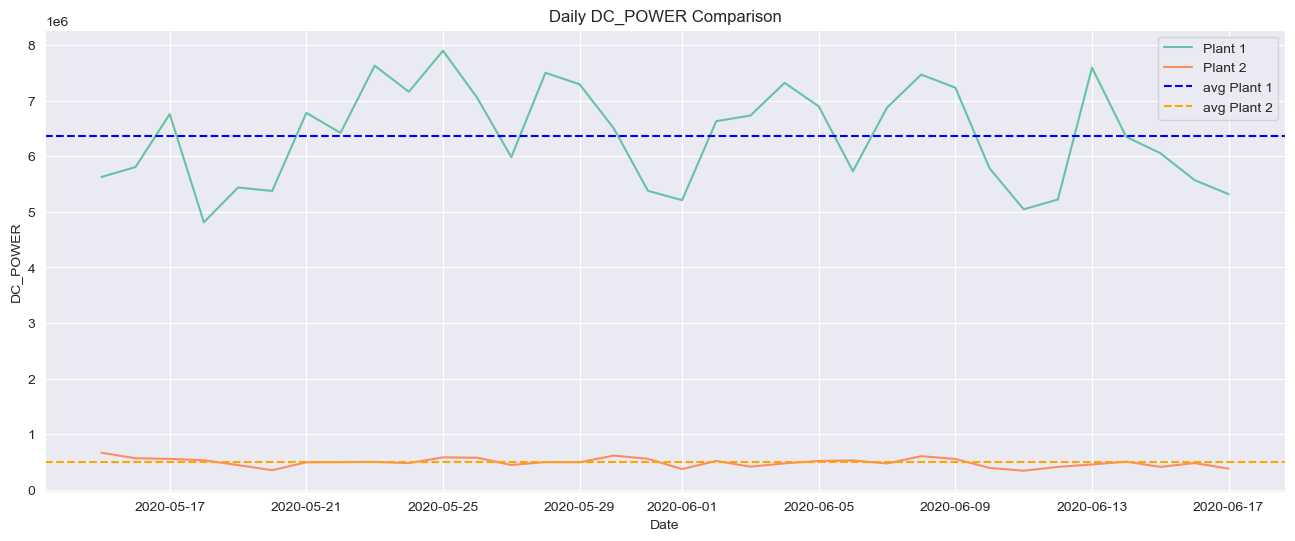

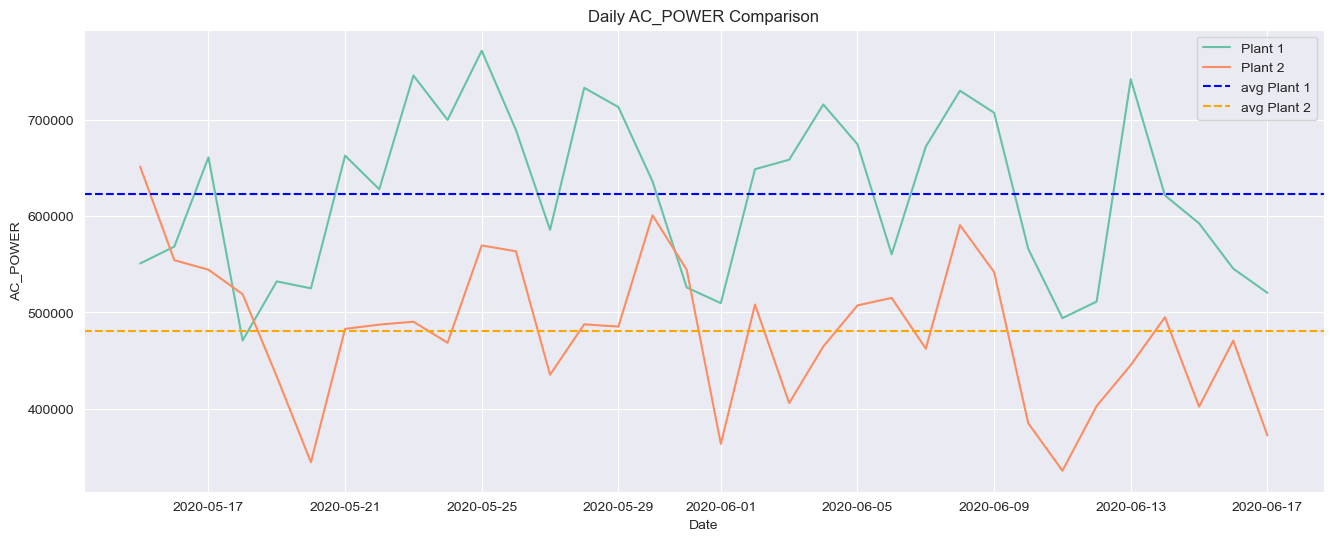

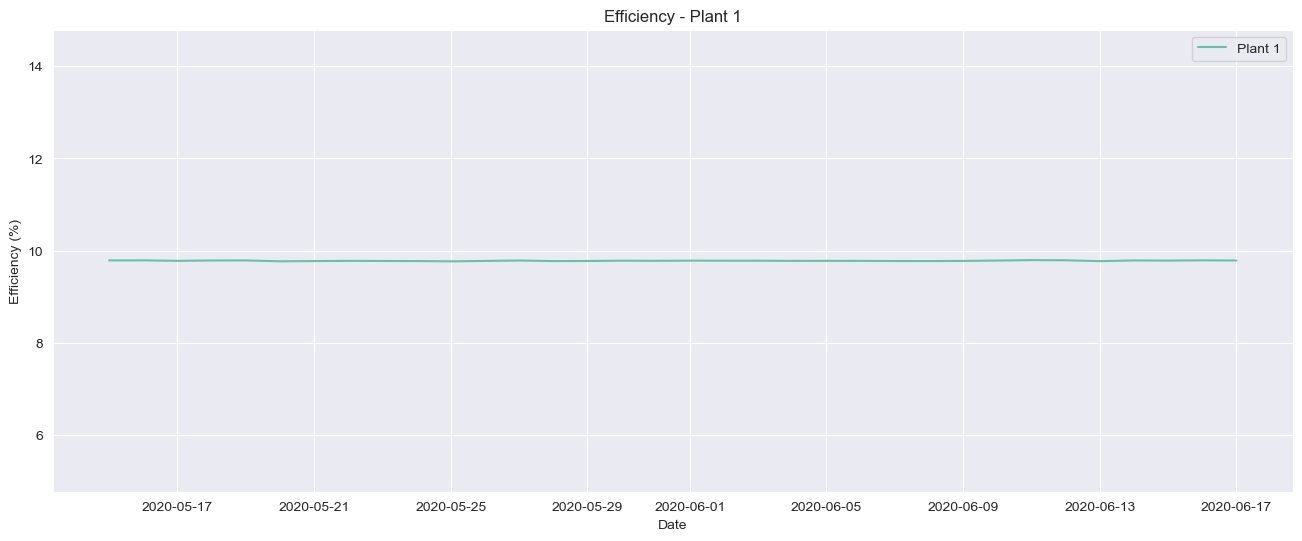

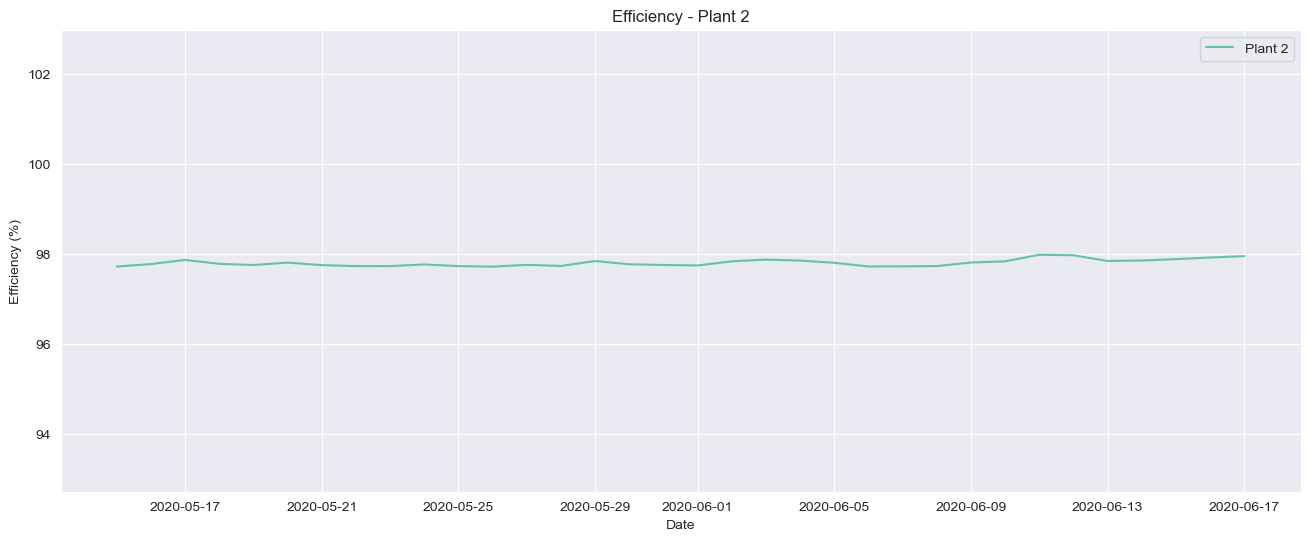

In [8]:
# Show power comparisons
showDailyPower(df_generation1, df_generation2, 'DC_POWER', 'Plant 1', 'Plant 2')
showDailyPower(df_generation1, df_generation2, 'AC_POWER', 'Plant 1', 'Plant 2')

# Efficiency analysis
def powerEfficiency(df_generation, label):
    df_generation['DATE'] = df_generation['DATE_TIME'].dt.date
    df = df_generation.groupby('DATE').sum(numeric_only=True)
    df['efficiency'] = df['AC_POWER'] * 100 / df['DC_POWER']
    
    plt.figure(figsize=(16, 6))
    plt.ylim(df['efficiency'].min() - 5, df['efficiency'].max() + 5)
    plt.title(f'Efficiency - {label}')
    sns.lineplot(x=df.index, y='efficiency', data=df, label=label)
    plt.xlabel('Date')
    plt.ylabel('Efficiency (%)')
    plt.legend()
    plt.show()

powerEfficiency(df_generation1, 'Plant 1')
powerEfficiency(df_generation2, 'Plant 2')



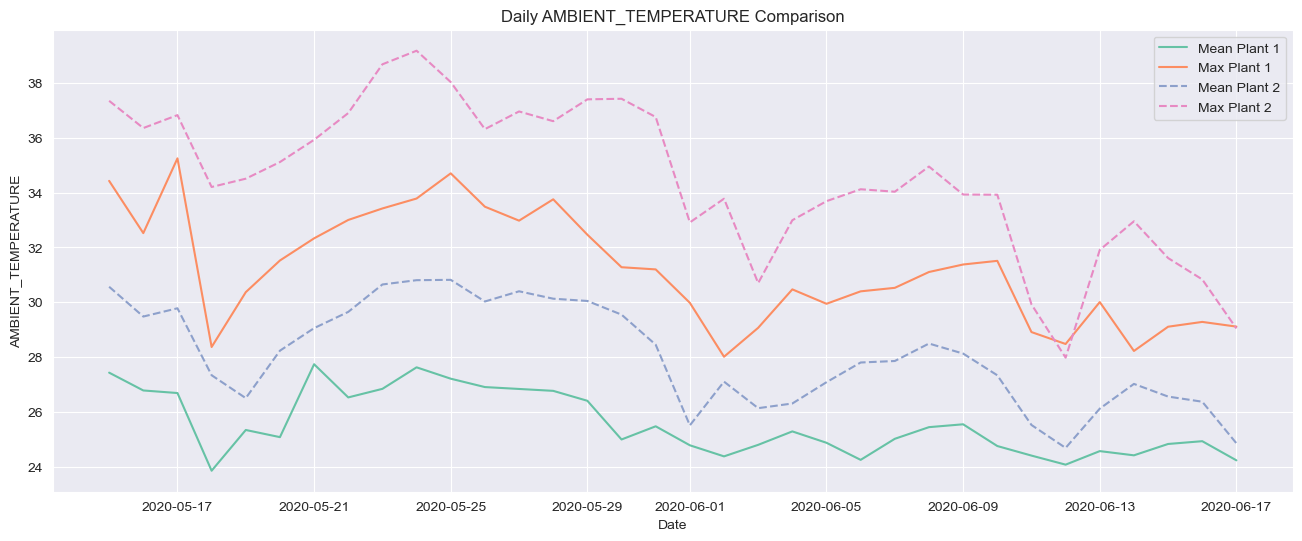

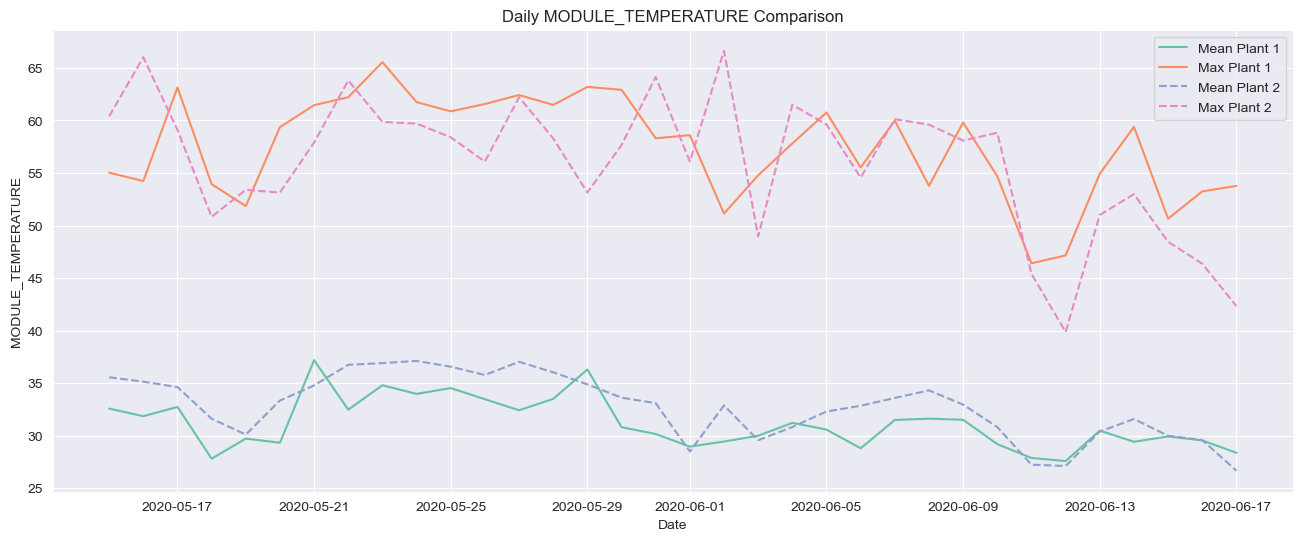

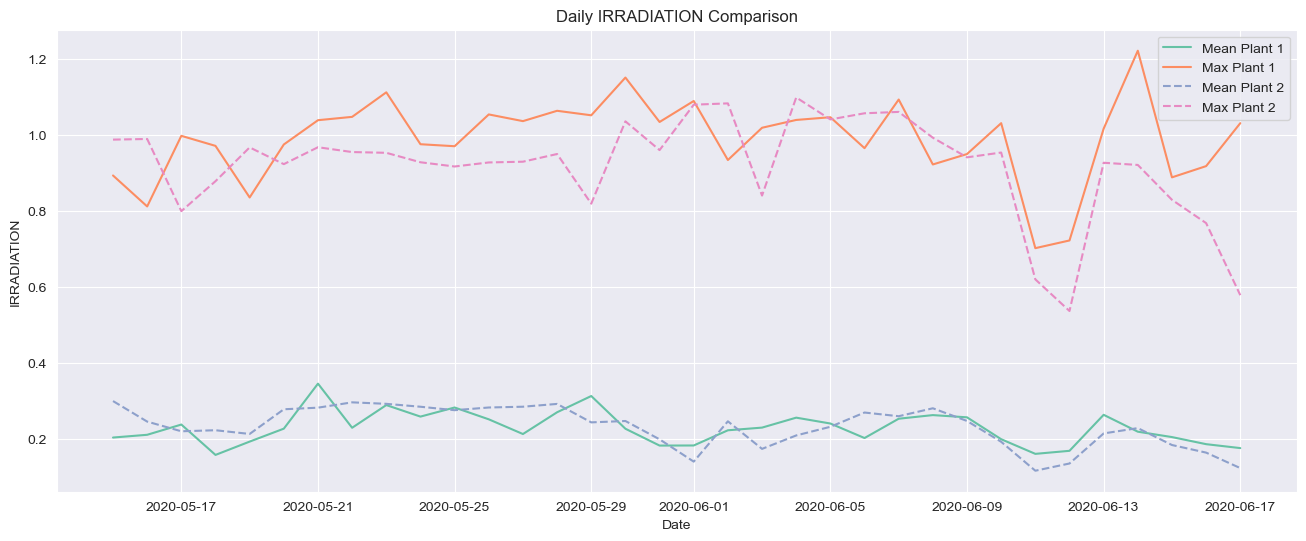

In [9]:
# Weather analysis
def groupDailyWeather(df_weather, operation):
    df_weather['DATE'] = df_weather['DATE_TIME'].dt.date
    if operation == 'mean':
        df_sorted = df_weather.groupby('DATE').mean(numeric_only=True)
    elif operation == 'max':
        df_sorted = df_weather.groupby('DATE').max(numeric_only=True)
    return df_sorted.sort_index()

def showDailyWeather(weather1, weather2, feature, label1, label2):
    df_sort1_mean = groupDailyWeather(weather1, 'mean')
    df_sort1_max = groupDailyWeather(weather1, 'max')
    df_sort2_mean = groupDailyWeather(weather2, 'mean')
    df_sort2_max = groupDailyWeather(weather2, 'max')
    
    plt.figure(figsize=(16, 6))
    plt.title(f'Daily {feature} Comparison')
    
    sns.lineplot(x=df_sort1_mean.index, y=df_sort1_mean[feature], label=f'Mean {label1}')
    sns.lineplot(x=df_sort1_max.index, y=df_sort1_max[feature], label=f'Max {label1}')
    sns.lineplot(x=df_sort2_mean.index, y=df_sort2_mean[feature], label=f'Mean {label2}', linestyle='dashed')
    sns.lineplot(x=df_sort2_max.index, y=df_sort2_max[feature], label=f'Max {label2}', linestyle='dashed')
    
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

showDailyWeather(df_weather1, df_weather2, 'AMBIENT_TEMPERATURE', 'Plant 1', 'Plant 2')
showDailyWeather(df_weather1, df_weather2, 'MODULE_TEMPERATURE', 'Plant 1', 'Plant 2')
showDailyWeather(df_weather1, df_weather2, 'IRRADIATION', 'Plant 1', 'Plant 2')



In [10]:
# Prediction implementation with Random Forest
def prepareData(df_sort, feature):
    n_bins = 12
    bins = np.linspace(df_sort[feature].min(), df_sort[feature].max(), n_bins)
    binned = np.digitize(df_sort[feature], bins)
    binned_series = pd.Series(binned, index=df_sort[feature].index)
    
    bin_means = {binn: df_sort['AC_POWER'][binned == binn].mean() for binn in range(1, n_bins+1)}
    
    lagged_list = [binned_series.shift(s) for s in range(13)]
    lagged_frame = pd.concat(lagged_list, axis=1).dropna()
    
    train_X = lagged_frame.iloc[:, 1:]
    train_y = lagged_frame.iloc[:, 0]
    
    return train_X, train_y, bin_means



In [11]:
# Prepare data
df_sort1 = groupDailyPower(df_generation1)
train_X1, train_y1, bin_means1 = prepareData(df_sort1, 'AC_POWER')

df_sort2 = groupDailyPower(df_generation2)
train_X2, train_y2, bin_means2 = prepareData(df_sort2, 'AC_POWER')

# Initialize Random Forest models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)  # Changed model
model1.fit(train_X1, train_y1)

model2 = RandomForestClassifier(n_estimators=100, random_state=42)  # Changed model
model2.fit(train_X2, train_y2)



RandomForestClassifier(random_state=42)

In [12]:
# Prediction functions
def meanFromClass(bin_means, prediction):
    return bin_means[prediction]  # Removed [0] indexing

# Update the prediction loop
def prediction(train_X, train_y, model, bin_means, df_sort):
    num_next_days = 12
    pred_insample = model.predict(train_X)
    
    last = np.array([pred_insample[-1]])  # Removed .astype(float)
    last_X = np.array(train_X)[-1]
    new_input = np.concatenate((last, last_X))[:12]
    
    result_predict = []
    for _ in range(num_next_days):
        result = model.predict(new_input.reshape(1, -1))
        result_predict.append(result[0])  # Keep [0] here as result is array
        new_input = np.concatenate((result, new_input))[:12]  # Simplified
    
    # Rest of the function remains the same
    
    pred_insample = np.concatenate((pred_insample, result_predict))
    new_index = newIndexDate(num_next_days, train_y)
    
    resulting_prediction = pd.Series(
        [meanFromClass(bin_means, val) for val in pred_insample],
        index=new_index
    )
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_sort['AC_POWER'], label='Actual')
    plt.plot(resulting_prediction, label='Predicted')
    plt.legend()
    plt.show()



Plant 1 Predictions:


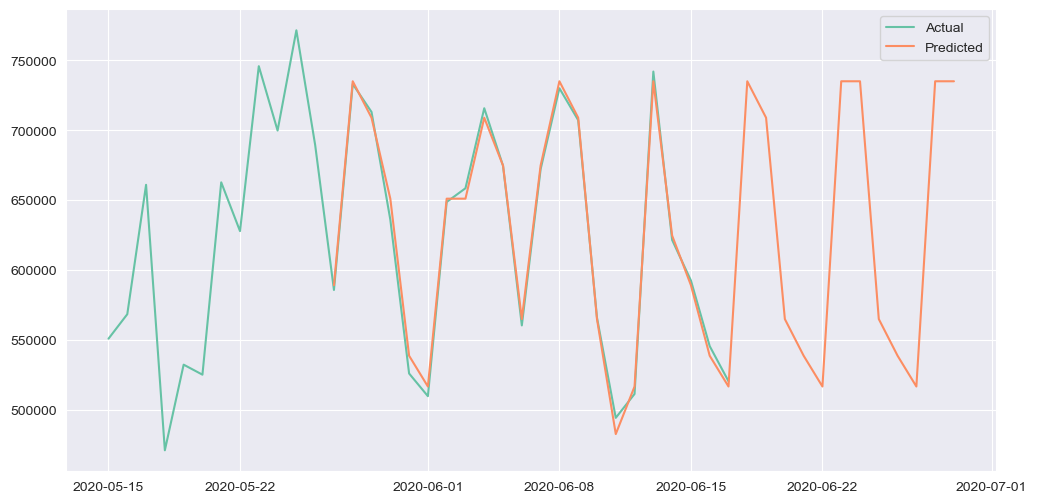


Plant 2 Predictions:


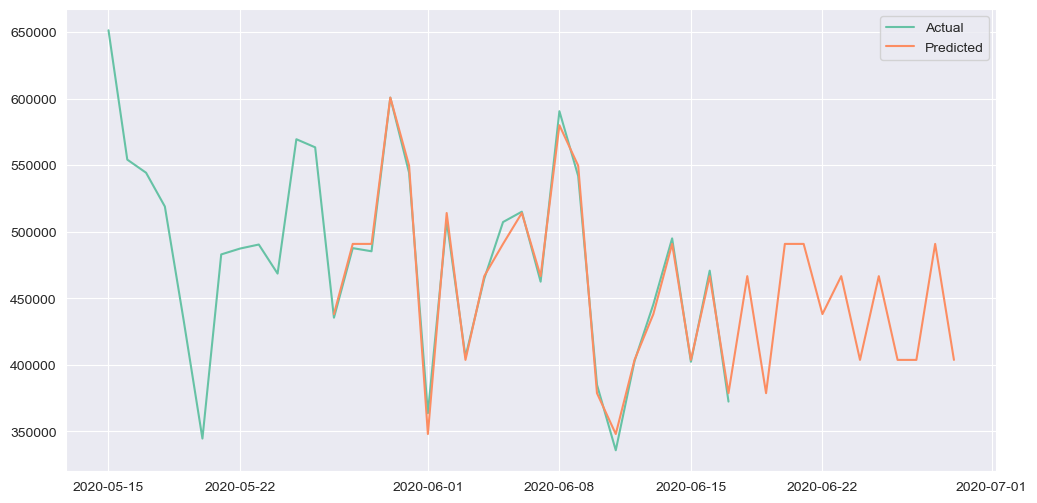

In [13]:
# Generate predictions
print("Plant 1 Predictions:")
prediction(train_X1, train_y1, model1, bin_means1, df_sort1)

print("\nPlant 2 Predictions:")
prediction(train_X2, train_y2, model2, bin_means2, df_sort2)

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Plant 1 Evaluation
y_pred1 = model1.predict(train_X1)
print("Plant 1 Accuracy:", accuracy_score(train_y1, y_pred1))
print("Plant 1 Confusion Matrix:\n", confusion_matrix(train_y1, y_pred1))
print("Plant 1 Classification Report:\n", classification_report(train_y1, y_pred1))

# Plant 2 Evaluation
y_pred2 = model2.predict(train_X2)
print("Plant 2 Accuracy:", accuracy_score(train_y2, y_pred2))
print("Plant 2 Confusion Matrix:\n", confusion_matrix(train_y2, y_pred2))
print("Plant 2 Classification Report:\n", classification_report(train_y2, y_pred2))


Plant 1 Accuracy: 1.0
Plant 1 Confusion Matrix:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 3]]
Plant 1 Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3

    accuracy                           1.00        22
   macro avg       1.00      1.00     